Authors: \
Marcin Gólski, 148262, SI3 \
Maciej Iwaszkiewicz, 148275, SI3

This notebook is the most basic realisation of the project requirements. Things like downloading 1000 random wikipedia articles and their lemmatization to prepare a local database can be examined in other notebooks (`scraping` and `lemmatization` respectively). Other notebooks might also contain some additional nuggets and insights into out process, but this one serves as our main report.

# Part 1. - Laying the groundwork and dataset exploration

In [2]:
# imports
# general functionality
import pandas as pd
import numpy as np

# similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.spatial.distance import cosine

# visualisation
# for getting items with extreme values from dictionaries
from operator import itemgetter
import matplotlib.pyplot as plt

In [4]:
path_to_lemmatized_data = "./data/articles.csv"
# we expect a .csv of the following structure:
# Title;Content
# where "Title" is the title of the article and "Content" is its, already preprocessed, content
basic_dataframe = pd.read_csv(path_to_lemmatized_data, sep=';')

The below function is **essential** to our recommender

It takes the path to the aforementioned csv as its argument and returns everything we need to know about our dataset **in the tf-idf space**

In [25]:
def initialise_tfidf_database(path_to_csv: str):
    # load database file
    # the documents are assumed to have been processed already
    documents_dataframe = pd.read_csv(path_to_csv, sep=';')
    documents_titles = documents_dataframe["Title"]
    documents_contents = documents_dataframe["Content"]

    # prepare tf-idf objects
    # smooth_idf=True: adds 1 to all term occurrences. Prevents dividing by 0
    # does not impact the results negatively, as the dataset is not tiny
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=True)
    # transform document contents to tf-idf space
    tfidf_data = tfidf_vectorizer.fit_transform(documents_contents).toarray()
    distinct_tfidf_terms = tfidf_vectorizer.get_feature_names_out()
    documents_dataframe_TFIDF = pd.DataFrame(tfidf_data, index = documents_titles, columns = distinct_tfidf_terms)

    # the vectorizer is needed later
    # it is needed for correct processing of documents from outside of the dataset
    return tfidf_vectorizer, documents_dataframe_TFIDF

### Creating our "tf-idf database"

In [27]:
# these variables are used extensively later on
tfidf_vectorizer, tfidf_database = initialise_tfidf_database(path_to_lemmatized_data)

## 1.1 Exploring most popular terms

In [6]:
def create_document_term_matrix(corpus: pd.DataFrame):
    contents = corpus["Content"]
    titles = corpus["Title"]
    count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
    counted_data = count_vectorizer.fit_transform(contents)
    document_term_matrix = pd.DataFrame(counted_data.toarray(), columns=count_vectorizer.get_feature_names_out(), index=titles)
    return document_term_matrix

Creating a document-term matrix. It will be used to conduct upcoming exploration \
Rows: documents \
Columns: terms \
Cells: number of times given term appears in the corresponding article

In [14]:
document_term_matrix = create_document_term_matrix(basic_dataframe)
document_term_matrix.head().iloc[:, :10]

,00,000,0005,000al,000children,000m,000m²,002,0052019,0071222
Title,,,,,,,,,,
Magnus Søndenå,0,0,0,0,0,0,0,0,0,0
Paul Francis Leibold,0,0,0,0,0,0,0,0,0,0
Baeksang Arts Award for Best Drama,0,0,0,0,0,0,0,0,0,0
Mandraka Dam,0,2,0,0,0,0,0,0,0,0
Leptocypris taiaensis,0,0,0,0,0,0,0,0,0,0


Preparing two dictionaries that store information on term popularity - total occurrences, and number of documents a given term appeared in

In [15]:
# should take under 10 seconds
# dictionary structure:
# key: term; value: tuple total occurrences of the term
occurrence_counting_dict = dict()
# key: term; value: number of documents this term appears in
document_counting_dict = dict()
for col in document_term_matrix.columns:
    total_occurrences = sum(document_term_matrix[col])
    different_docs = len(np.where(document_term_matrix[col]>0)[0])
    occurrence_counting_dict[col] = total_occurrences
    document_counting_dict[col] = different_docs

### 1.1.1 Terms that occurred the most times over the dataset

In [16]:
sorted_by_occurrences = sorted(occurrence_counting_dict.items(), key = itemgetter(1), reverse = True)

In [17]:
most_occurrences_to_show = 20
most_occurrences =  dict(sorted_by_occurrences[:most_occurrences_to_show])

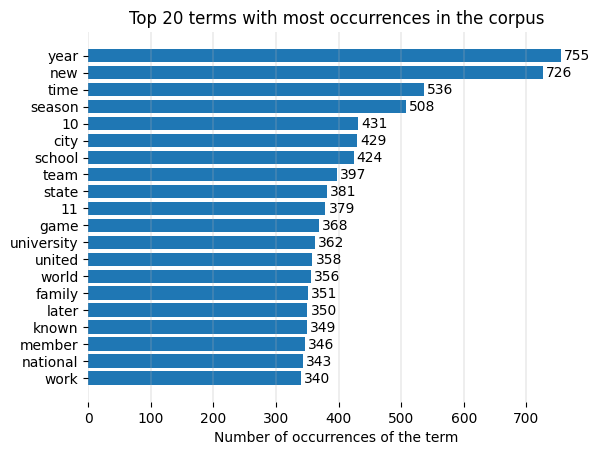

In [18]:
fig, ax = plt.subplots()
ax.grid(axis='x', linewidth=0.3)
ax.barh(list(most_occurrences.keys()), most_occurrences.values())
for i, value in enumerate(most_occurrences.values()):
    # this does not change the value the '+' simply moves the text n units to the right
    ax.text(value+5, i + .25, str(value))
# remove the box surrouding the plot
for position in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[position].set_visible(False)
ax.invert_yaxis()
ax.set_title(f"Top {most_occurrences_to_show} terms with most occurrences in the corpus")
ax.set_xlabel("Number of occurrences of the term")
plt.show()

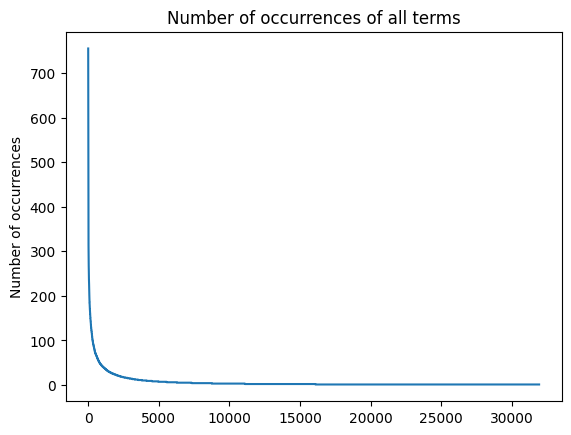

In [19]:
plt.plot(range(len(sorted_by_occurrences)), np.array(sorted_by_occurrences)[:, 1].astype('int'))
plt.title("Number of occurrences of all terms")
plt.ylabel("Number of occurrences")
plt.show()

### 1.1.2 Terms that occurred in the largest number of documetns

In [20]:
sorted_by_doc_count = sorted(document_counting_dict.items(), key = itemgetter(1), reverse = True)

In [21]:
most_doc_appearances_to_show = 20
most_documents =  dict(sorted_by_doc_count[:most_doc_appearances_to_show])

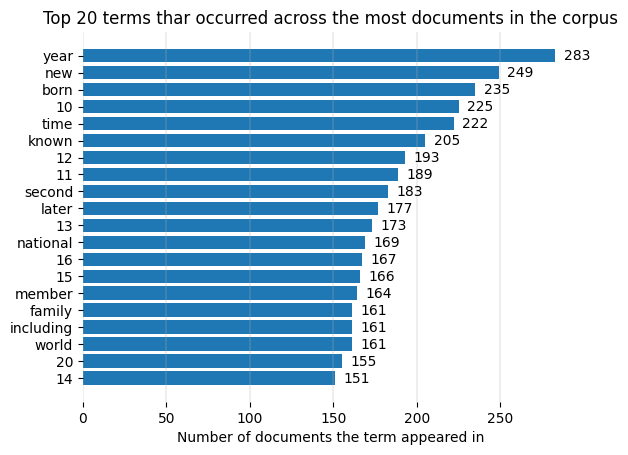

In [22]:
fig, ax = plt.subplots()
ax.grid(axis='x', linewidth=0.3)
ax.barh(list(most_documents.keys()), most_documents.values())
for i, value in enumerate(most_documents.values()):
    # this does not change the value the '+' simply moves the text n units to the right
    ax.text(value+5, i + .25, str(value))
# remove the box surrouding the plot
for position in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[position].set_visible(False)
ax.invert_yaxis()
ax.set_title(f"Top {most_doc_appearances_to_show} terms thar occurred across the most documents in the corpus")
ax.set_xlabel("Number of documents the term appeared in")
plt.show()

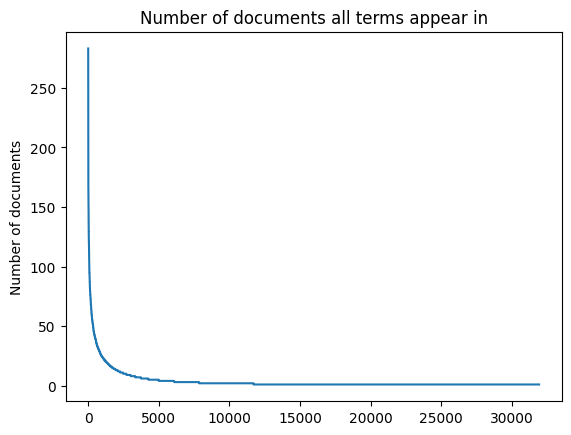

In [23]:
plt.plot(range(len(sorted_by_doc_count)), np.array(sorted_by_doc_count)[:, 1].astype('int'))
plt.title("Number of documents all terms appear in")
plt.ylabel("Number of documents")
plt.show()

## 1.2 Pairs of most similar documents

Compute similarities between all pairs of documents in the database. We will discard many of them, due to low similarities being abundant and not interesting.

In [28]:
# Long computation! 2minutes+
similarity_dict = dict()
for i in range(len(tfidf_database)-1):
    for j in range(i+1, len(tfidf_database)):
        name_i = tfidf_database.iloc[i].name
        name_j = tfidf_database.iloc[j].name
        cosine_sim = 1 - cosine(tfidf_database.iloc[i], tfidf_database.iloc[j])
        # to avoid storing too many documents
        if cosine_sim > 0.1:
            similarity_dict[(name_i, name_j)] = cosine_sim

In [29]:
top_pairs_to_show = 20
top_similarities =  dict(sorted(similarity_dict.items(), key = itemgetter(1), reverse = True)[:top_pairs_to_show])

In [35]:
for key in top_similarities.keys():
    # pair of document titles, cosine similarity between them
    # not unpacking the key, in order to maintain a clear disticntion between the two document tiles
    print(key, top_similarities[key])

('Ochtman', 'Furnas (surname)') 0.7183107789108444
('Ochtman', 'Kluckhohn') 0.7183107789108444
('Ochtman', 'Applin') 0.7183107789108444
('Ochtman', 'Delpirou') 0.7183107789108444
('Ochtman', 'Corrente (surname)') 0.7183107789108444
('Ochtman', 'Ravilious') 0.7183107789108444
('Ochtman', 'Panagi') 0.7183107789108444
('Ochtman', 'Perenchio') 0.7183107789108444
('Furnas (surname)', 'Kluckhohn') 0.7183107789108444
('Furnas (surname)', 'Applin') 0.7183107789108444
('Furnas (surname)', 'Delpirou') 0.7183107789108444
('Furnas (surname)', 'Corrente (surname)') 0.7183107789108444
('Furnas (surname)', 'Ravilious') 0.7183107789108444
('Furnas (surname)', 'Panagi') 0.7183107789108444
('Furnas (surname)', 'Perenchio') 0.7183107789108444
('Kluckhohn', 'Applin') 0.7183107789108444
('Kluckhohn', 'Delpirou') 0.7183107789108444
('Kluckhohn', 'Corrente (surname)') 0.7183107789108444
('Kluckhohn', 'Ravilious') 0.7183107789108444
('Kluckhohn', 'Panagi') 0.7183107789108444


All surname list articles have exactly the same structure. Example:
> Furnas surname notable people surname include

Where "Furnas" is replaced by the appropriate surname
That's why the top spots are occupied by surname articles - they all share 5/6 of their terms.

For a couple extra insights, see `dataset_exploration.ipynb`

---